In [1]:
import timeit
import os
import math                                                 # basic calculations like square root
import numpy as np                                          # arrays and matrix math
import scipy.stats as st                                    # statistical methods
import matplotlib.pyplot as plt                             # for plotting
import geostatspy.GSLIB as GSLIB                            # GSLIB utilies, visualization and wrapper
import seaborn as sns
import pandas as pd                                         # DataFrames
import pandas.plotting as pd_plot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours
from sklearn import metrics                                 # measures to check our models
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.ensemble import BaggingRegressor   
from sklearn.ensemble import RandomForestRegressor          # random forest method
from sklearn.model_selection import KFold

data_path = "Data/"
plot_path = "Plot/"

df = pd.read_csv(data_path+'01_Trend_Model_Oil.csv')
df.describe()

def bagging_knn (seeds,x,y,xx,yy,num_k):
    bagging_models = []; 
    index = 1
    regressor = KNeighborsRegressor(weights = 'distance', n_neighbors=num_k, p = 2) 
    for seed in seeds:                                          # loop over random number seeds
        bagging_models.append(BaggingRegressor(base_estimator=regressor, n_estimators=1,random_state=seed, bootstrap=True, n_jobs = -1))
        bagging_models[index-1].fit(X = x , y = y)
        index = index + 1      
    index = 1
    for seed in seeds:                                       
        if index == 1:
            z = bagging_models[0].predict(np.c_[xx.ravel(), yy.ravel()])
            z = z.reshape(xx.shape)
        else:
            z_t = bagging_models[index-1].predict(np.c_[xx.ravel(), yy.ravel()])
            z_t = z_t.reshape(xx.shape)
            z = z + z_t                 
        index = index + 1
    z = z / len(seeds)
    
    i = 0
    while i < xx.shape[0]:
        j = 0
        while j < xx.shape[1]:
            L1 = np.min( euclidean_distances(x,[[xx[i,j],yy[i,j]]]) ) # get L1 to N-Neighbors
            if L1 > 0.5e5:
                z[i,j] = np.nan;
            j += 1
        i += 1 
    return z,bagging_models
##############################################################################################
def plot_bag_knn (xx,yy,z,prodmax,prodmin,max_num_bags,well_x,well_y,well_z):
    plt.figure(figsize=(11,7))
    cmap = plt.cm.RdYlBu_r
    cs = plt.contourf(xx, yy, z, cmap=cmap,vmin=prodmin, vmax=prodmax, levels=np.linspace(prodmin, prodmax, 100))
    plt.ticklabel_format(style='sci', scilimits=(0,0))
    cbar = plt.colorbar(cs, orientation = 'vertical',format='%.0e')
    cbar.set_label(PARA_3+' (bbl)', rotation=270, labelpad=20)
    plt.title('Oil EUR Trend - Aggregation of %i KNN Realizations'%max_num_bags,fontsize=14)
    plt.xlabel('West-East, Relative Location',fontsize=10); 
    plt.ylabel('North-South, Relative Location',fontsize=10)
    plt.xlim(xmin,xmax); plt.ylim(ymin,ymax);
    plt.ticklabel_format(style='sci', scilimits=(0,0))  
def plot_bag_knn_accuracy(df,bagging_models1,x,seeds,PARA_3): 
    bagging_models = bagging_models1
    index = 1
    z = []
    for seed in seeds:                                          # loop over random number seeds
        if index == 1:
            z = bagging_models[0].predict(x)
        else:
            z_t = bagging_models[index-1].predict(x)
            z = z + z_t
        index = index + 1
    predict = z / len(seeds)
    plt.figure(figsize=(6,4))
    plt.scatter(df[PARA_3],predict,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.1, verts=None, edgecolors="black")
    plt.suptitle('Model Check KNN with Bagging '); plt.xlabel('Actual Oil EUR'); plt.ylabel('Estimated Oil EUR')
    plt.xlim(0,6e5); plt.ylim(0,6e5)
    plt.arrow(0,0,6e5,6e5,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(df[PARA_3],predict)
    Var_Explained = metrics.explained_variance_score(df[PARA_3],predict)
    cor = math.sqrt(metrics.r2_score(df[PARA_3],predict))
    plt.title('MSE = %.2f, VE = %.2f, R^2 = %.2f' %(round(MSE,2),round(Var_Explained,2), round(cor,2)),fontsize=10)
    plt.ticklabel_format(style='sci', scilimits=(0,0))
    return 
def plot_bag_knn_return_predictions(df,bagging_models1,x,seeds,PARA_3): 
    bagging_models = bagging_models1
    index = 1
    z = []
    for seed in seeds:                                          # loop over random number seeds
        if index == 1:
            z = bagging_models[0].predict(x)
        else:
            z_t = bagging_models[index-1].predict(x)
            z = z + z_t
        index = index + 1
    predict = z / len(seeds)
    return predict
##############################################################################################  
def bagging_knn_KFold (seeds,x,y,xx,num_k):
    # x:train location; y:EUR; XX:test location
    bagging_models = []; 
    index = 1
    regressor = KNeighborsRegressor(weights = 'distance', n_neighbors=num_k, p = 2) 
    for seed in seeds:                                          # loop over random number seeds
        bagging_models.append(BaggingRegressor(base_estimator=regressor, n_estimators=1,random_state=seed, bootstrap=True, n_jobs = -1))
        bagging_models[index-1].fit(X = x , y = y)
        index = index + 1      
    index = 1
    for seed in seeds:                                       
        if index == 1:
            z = bagging_models[0].predict(xx)
        else:
            z_t = bagging_models[index-1].predict(xx)
            z = z + z_t                 
        index = index + 1
    z = z / len(seeds)
    return z
def my_kfold_cross_validation(X,Y,num_k,num_fold):
    kf = KFold(n_splits=num_fold,shuffle=True, random_state=77777)
    VE = []; MSE =[]
    index_fold = 1
    for train_index, test_index in kf.split(X):
        # each looping cycle is 1 fold
        z1 = []; bagging_models1 = []
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        z1 = bagging_knn_KFold (seeds,X_train,Y_train,X_test,num_k)
        VE.append(metrics.explained_variance_score(Y_test,z1))
        MSE.append(metrics.mean_squared_error(Y_test,z1))
        index_fold += 1    
    return np.average(VE),np.average(MSE)

,Name,x,y,Oil_EUR,Gas_EUR
count,3.603000e+03,3.603000e+03,3603.000000,3603.000000,3.603000e+03
mean,4.225556e+13,2.112103e+06,297418.292978,115018.110741,6.109890e+05
std,1.253052e+11,2.849103e+05,147646.473714,86516.954962,8.045974e+05
min,4.201330e+13,1.551359e+06,-62050.100000,0.000000,0.000000e+00
25%,4.212730e+13,1.840242e+06,181581.000000,51405.500000,1.081230e+05
50%,4.225530e+13,2.125927e+06,277182.700000,99143.000000,2.734020e+05
75%,4.229740e+13,2.366351e+06,410129.850000,159366.000000,8.291080e+05
max,4.250730e+13,2.603085e+06,664462.600000,448642.000000,7.950157e+06


In [2]:
PARA_1 = 'x';    PARA_2 = 'y';   PARA_3 = 'Oil_EUR'

prodmax = np.max(df[PARA_3]);        prodmin = np.min(df[PARA_3])
xmin = np.min(df[PARA_1]);           xmax = np.max(df[PARA_1]); 
ymin = np.min(df[PARA_2]);           ymax = np.max(df[PARA_2])
xx, yy = np.meshgrid(np.arange(xmin, xmax, 1e4),np.arange(ymin, ymax, 5e2))

ini_k = 5;  max_k = 12;  increment_k = 2;  
linespace_k = np.arange(ini_k,max_k,increment_k)
linespace_k

array([ 5,  7,  9, 11])

In [3]:
num_fold = 8
X = np.c_[df[PARA_1],df[PARA_2]];    Y = df[PARA_3]      
bag = 1;      max_bags = 100
seed_start = 77078
VE_bags = []; MSE_bags =[]

for num_k in linespace_k :
    start_time = timeit.default_timer()
    bag = 1;
    while bag <= max_bags:
        seeds = np.arange(seed_start, seed_start+bag, 1)
        VE,MSE = my_kfold_cross_validation(X,Y,num_k,num_fold)
        VE_bags.append(VE)    
        MSE_bags.append(MSE)  
        bag += 1  
    print ('k #%.0f : %.3f'%(num_k,(timeit.default_timer() - start_time))+"sec")
    
VE_bags = pd.DataFrame(VE_bags)
MSE_bags = pd.DataFrame(MSE_bags)
VE_bags.to_csv(data_path+'Oil_Trend_Num_Bags_8Fold_VE.csv',index=False)
MSE_bags.to_csv(data_path+'Oil_Trend_Num_Bags_8Fold_MSE.csv',index=False)

k #5 : 148.637sec
k #7 : 149.899sec
k #9 : 150.267sec
k #11 : 155.753sec


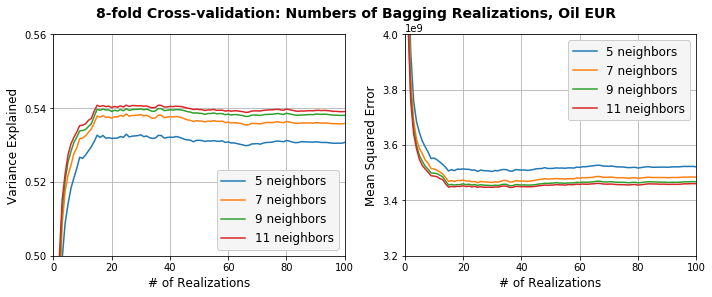

In [4]:
fig, ((ax1,ax2)) = plt.subplots(1, 2,figsize=(10, 4))

VE_bags = pd.read_csv(data_path+'Oil_Trend_Num_Bags_8Fold_VE.csv')
MSE_bags= pd.read_csv(data_path+'Oil_Trend_Num_Bags_8Fold_MSE.csv')
linespace_bags = np.arange(1, 101, 1)

index = 0
for k in linespace_k:
    DC = 'C'+str(index)
    ax1.plot(linespace_bags,VE_bags[0+index*100:100+index*100],color=DC,
             label = '%i neighbors'%k)
    ax2.plot(linespace_bags,MSE_bags[0+index*100:100+index*100],color=DC,
             label = '%i neighbors'%k)
    index += 1
    
ax1.legend(loc='lower right',framealpha=1,fontsize=12,facecolor='whitesmoke')
ax1.set_xlim(0,max_bags); 
ax1.set_ylim(0.5,0.56); 
ax1.set_yticks(np.arange(0.5, 0.56, step=0.02))
ax1.set_xlabel('# of Realizations',fontsize=12);
ax1.set_ylabel('Variance Explained',fontsize=12);
ax1.grid()
ax2.set_xlim(0,max_bags); 
ax2.set_ylim(3.2e9, 4e9); 
ax2.set_yticks(np.arange(3.2e9, 4.1e9, step=0.2e9))
ax2.legend(loc='upper right',framealpha=1,fontsize=12,facecolor='whitesmoke')
ax2.set_xlabel('# of Realizations',fontsize=12);
ax2.set_ylabel('Mean Squared Error',fontsize=12);
ax2.grid()
fig.suptitle('8-fold Cross-validation: Numbers of Bagging Realizations, Oil EUR',fontweight='bold',y=1.02,fontsize=14);
fig.tight_layout()
plt.savefig(plot_path+'02_Oil_CrossValidation_bags.png', dpi=300,bbox_inches='tight')

In [7]:
ini_k = 1;  max_k = 31;  increment_k = 1;  
linespace_k =  np.arange(ini_k,max_k,increment_k)
# 
bag = 30;
# 
num_fold = 8
X = np.c_[df[PARA_1],df[PARA_2]];    Y = df[PARA_3]      

seed_start = 77077
VE_K = []; MSE_K =[]

for num_k in linespace_k :
    start_time = timeit.default_timer()   
    seeds = np.arange(seed_start, seed_start+bag, 1)
    VE,MSE = my_kfold_cross_validation(X,Y,num_k,num_fold)
    VE_K.append(VE)    
    MSE_K.append(MSE)  
    bag += 1  
    
VE_K = pd.DataFrame(VE_K)
MSE_K = pd.DataFrame(MSE_K)
VE_K.to_csv(data_path+'Oil_Trend_Num_neighbor_8Fold_VE.csv',index=False)
MSE_K.to_csv(data_path+'Oil_Trend_Num_neighbor_8Fold_MSE.csv',index=False)

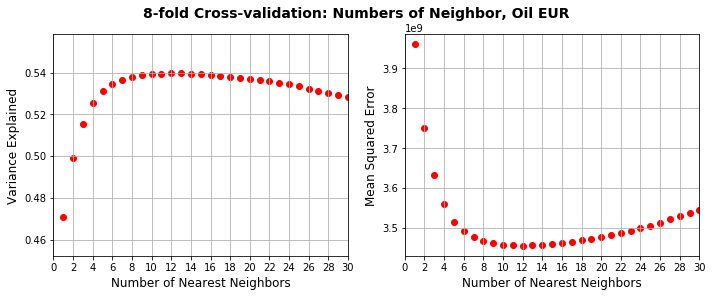

In [6]:
VE_K = pd.read_csv(data_path+'Oil_Trend_Num_neighbor_8Fold_VE.csv')
MSE_K= pd.read_csv(data_path+'Oil_Trend_Num_neighbor_8Fold_MSE.csv')

fig, ((ax1,ax2)) = plt.subplots(1, 2,figsize=(10, 4))
ax1.scatter(linespace_k,VE_K,color='red')
ax1.set_xlabel('Number of Nearest Neighbors',fontsize=12);
ax1.set_ylabel('Variance Explained',fontsize=12);
ax1.set_xlim(0,30); ax2.set_xticks(np.arange(0, max_k, step=2))

ax2.scatter(linespace_k,MSE_K,color='red')
ax2.set_xlabel('Number of Nearest Neighbors',fontsize=12);
ax2.set_ylabel('Mean Squared Error',fontsize=12);
ax2.set_xlim(0,30); ax1.set_xticks(np.arange(0, max_k, step=2))

ax1.grid()
ax2.grid()
fig.suptitle('8-fold Cross-validation: Numbers of Neighbor, Oil EUR',fontweight='bold',y=1.02,fontsize=14);
fig.tight_layout()
plt.savefig(plot_path+'02_Oil_CrossValidation_neighbors.png', dpi=300,bbox_inches='tight')

In [10]:
start_time = timeit.default_timer()

max_num_bags = 30
num_k = 12

df = pd.read_csv(data_path+'01_Trend_Model_Oil.csv')
x = np.c_[df[PARA_1],df[PARA_2]];    y = df[PARA_3]
prodmax = np.max(df[PARA_3]);        prodmin = np.min(df[PARA_3])
xmin = np.min(df[PARA_1]);           xmax = np.max(df[PARA_1]); 
ymin = np.min(df[PARA_2]);           ymax = np.max(df[PARA_2])
xx, yy = np.meshgrid(np.arange(xmin, xmax, 1e4),np.arange(ymin, ymax, 5e2))
start = 77077
seeds = np.arange(start, start+max_num_bags, 1)

z1,bagging_models1 = bagging_knn (seeds,x,y,xx,yy,num_k)

print (timeit.default_timer() - start_time)

43.2076437249998


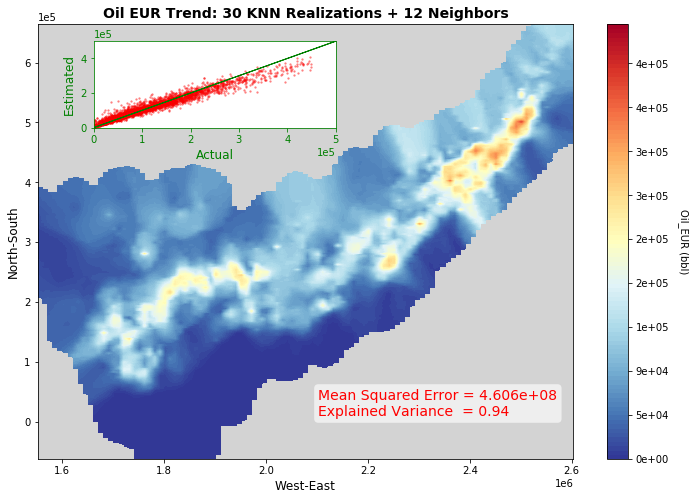

In [11]:
fig, ax1 = plt.subplots(figsize=(12,8))
cmap = plt.cm.RdYlBu_r
cs = ax1.contourf(xx, yy, z1, cmap=cmap,vmin=prodmin, vmax=prodmax, levels=np.linspace(prodmin, prodmax, 100))
cbar = plt.colorbar(cs, orientation = 'vertical',format='%.0e')
ax1.set_xlabel('West-East',fontsize=12); 
ax1.set_ylabel('North-South',fontsize=12)
ax1.ticklabel_format(style='sci', scilimits=(0,0))
cbar.set_label(PARA_3+' (bbl)', rotation=270, labelpad=20)
ax1.set_title('Oil EUR Trend: %i KNN Realizations + %i Neighbors'%(max_num_bags,num_k),
              fontsize=14,fontweight='bold')
ax1.set_xlim(xmin,xmax); ax1.set_ylim(ymin,ymax);
ax1.ticklabel_format(style='sci', scilimits=(0,0))  

left, bottom, width, height = [0.19, 0.7, 0.28, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlabel('Actual',color='green',fontsize=12);  ax2.set_ylabel('Estimated',color='green',fontsize=12); 
ax2.set_xlim(0,5e5); ax2.set_ylim(0,5e5)
ax2.ticklabel_format(style='sci', scilimits=(0,0))
ax2.arrow(0,0,6e6,6e6,width=0.02,color='green',head_length=0.0,head_width=0.0)
predict_val = plot_bag_knn_return_predictions(df,bagging_models1,x,seeds,PARA_3)
ax2.scatter(df[PARA_3],predict_val,s=5,c='red',marker=None, cmap=None, norm=None, 
            vmin=None, vmax=None, alpha=0.5, linewidths=0.01, verts=None, edgecolors="black")

MSE = metrics.mean_squared_error(df[PARA_3],predict_val)
Var_Explained = metrics.explained_variance_score(df[PARA_3],predict_val)
text =('Mean Squared Error = %.3e\n\
Explained Variance  = %.2f' %(round(MSE,2),round(Var_Explained,2)))
props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.8, edgecolor='none')        
fig.text(0.45,0.2, text, size=12,bbox=props,fontsize=14,color ='red')
ax2.spines['bottom'].set_color('green')
ax2.spines['top'].set_color('green')
ax2.spines['left'].set_color('green')
ax2.spines['right'].set_color('green')
ax2.xaxis.label.set_color('green')
ax2.tick_params(axis='both', colors='green')

ax1.set_facecolor('lightgray')
plt.savefig(plot_path+'02_Oil_KNN_Map_1.png', dpi=300,bbox_inches='tight')

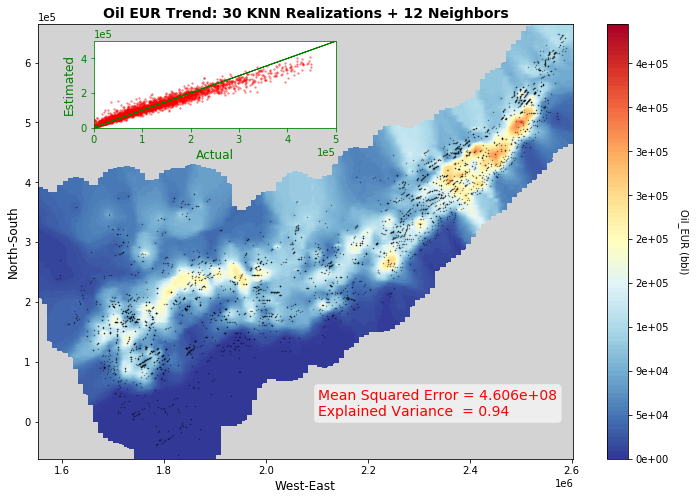

In [12]:
fig, ax1 = plt.subplots(figsize=(12,8))
cmap = plt.cm.RdYlBu_r
cs = ax1.contourf(xx, yy, z1, cmap=cmap,vmin=prodmin, vmax=prodmax, levels=np.linspace(prodmin, prodmax, 100))
cbar = plt.colorbar(cs, orientation = 'vertical',format='%.0e')
ax1.set_xlabel('West-East',fontsize=12); 
ax1.set_ylabel('North-South',fontsize=12)
ax1.ticklabel_format(style='sci', scilimits=(0,0))
cbar.set_label(PARA_3+' (bbl)', rotation=270, labelpad=20)
ax1.set_title('Oil EUR Trend: %i KNN Realizations + %i Neighbors'%(max_num_bags,num_k),
              fontsize=14,fontweight='bold')
ax1.set_xlim(xmin,xmax); ax1.set_ylim(ymin,ymax);
ax1.ticklabel_format(style='sci', scilimits=(0,0))  

left, bottom, width, height = [0.19, 0.7, 0.28, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlabel('Actual',color='green',fontsize=12);  ax2.set_ylabel('Estimated',color='green',fontsize=12); 
ax2.set_xlim(0,5e5); ax2.set_ylim(0,5e5)
ax2.ticklabel_format(style='sci', scilimits=(0,0))
ax2.arrow(0,0,6e6,6e6,width=0.02,color='green',head_length=0.0,head_width=0.0)
predict_val = plot_bag_knn_return_predictions(df,bagging_models1,x,seeds,PARA_3)
ax2.scatter(df[PARA_3],predict_val,s=5,c='red',marker=None, cmap=None, norm=None, 
            vmin=None, vmax=None, alpha=0.5, linewidths=0.01, verts=None, edgecolors="black")

MSE = metrics.mean_squared_error(df[PARA_3],predict_val)
Var_Explained = metrics.explained_variance_score(df[PARA_3],predict_val)
text =('Mean Squared Error = %.3e\n\
Explained Variance  = %.2f' %(round(MSE,2),round(Var_Explained,2)))
props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.8, edgecolor='none')        
fig.text(0.45,0.2, text, size=12,bbox=props,fontsize=14,color ='red')
ax2.spines['bottom'].set_color('green')
ax2.spines['top'].set_color('green')
ax2.spines['left'].set_color('green')
ax2.spines['right'].set_color('green')
ax2.xaxis.label.set_color('green')
ax2.tick_params(axis='both', colors='green')
ax1.scatter(df[PARA_1], df[PARA_2],alpha=0.5,s=0.2,color='black');
ax1.set_facecolor('lightgray')
plt.savefig(plot_path+'02_Oil_KNN_Map_2.png', dpi=300,bbox_inches='tight')

In [1]:
%reset -f